In [597]:
# General imports
import os
import re
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

In [598]:
# Import data
initial_data = '../data/initial/'

# Import mask use by county
df_masks = pd.read_csv(initial_data + 'covid_mask_use.csv')

# Import cases by county
df_counties = pd.read_csv(initial_data + 'covid_us_counties.csv')

In [599]:
df_masks.dropna(inplace=True)
df_masks.head()

,county_fips_code,never,rarely,sometimes,frequently,always
0,15007,0.0,0.021,0.046,0.108,0.825
1,36011,0.0,0.033,0.072,0.162,0.732
2,48209,0.0,0.007,0.022,0.115,0.855
3,51740,0.0,0.019,0.122,0.225,0.634
4,17019,0.0,0.067,0.080,0.192,0.661


In [600]:
df_counties.dropna(inplace=True)
df_counties.head()

,date,county,state_name,county_fips_code,confirmed_cases,deaths
0,2020-07-14,Adair,Iowa,19001.0,17,0
1,2020-07-15,Adair,Iowa,19001.0,17,0
2,2020-07-16,Adair,Iowa,19001.0,19,0
3,2020-07-17,Adair,Iowa,19001.0,19,0
4,2020-07-18,Adair,Iowa,19001.0,20,0


In [601]:
df_masks.shape

(3142, 6)

In [602]:
df_counties.shape

(648129, 6)

In [603]:
# Convert county_fips_code to integer value
df_counties.county_fips_code = df_counties.county_fips_code.astype(int)

In [604]:
# Filter counties that are only present in the df_masks dataset
df_counties = pd.merge(df_counties, df_masks.county_fips_code, how='inner', on='county_fips_code')
df_counties.shape

(634109, 6)

In [605]:
# Convert 'date' column to datetime object
df_counties.date = pd.to_datetime(df_counties.date)

In [606]:
# Number of unique counties?
unique_county_codes = np.unique(df_counties.county_fips_code)
print('Number of unique counties: {}'.format(len(unique_county_codes)))

Number of unique counties: 3132


In [607]:
# Filter a dataframe's by the counties present in the df_masks dataframe
# We assume we the input dataframe has a 'county_fips_code' attribute
def filter_county_rows(df):
    return df[pd.Series(map(lambda x: x in unique_county_codes, df.county_fips_code))]

In [608]:
# Keep only counties present in the df_counties data set
# df_masks = df_masks[pd.Series(map(lambda x: x in unique_county_codes, df_masks.county_fips_code))]
df_masks = filter_county_rows(df_masks)

In [609]:
# Sort masks data set by county code (ascending)
df_masks = df_masks.sort_values('county_fips_code').reset_index().drop('index', axis=1)
df_masks.head()

,county_fips_code,never,rarely,sometimes,frequently,always
0,1001,0.053,0.074,0.134,0.295,0.444
1,1003,0.083,0.059,0.098,0.323,0.436
2,1005,0.067,0.121,0.120,0.201,0.491
3,1007,0.020,0.034,0.096,0.278,0.572
4,1009,0.053,0.114,0.180,0.194,0.459


In [610]:
# Sort counties data set by county code and then date
df_counties = df_counties.sort_values(['county_fips_code', 'date']).reset_index().drop('index', axis=1)
df_counties.head()

,date,county,state_name,county_fips_code,confirmed_cases,deaths
0,2020-03-24,Autauga,Alabama,1001,1,0
1,2020-03-25,Autauga,Alabama,1001,4,0
2,2020-03-26,Autauga,Alabama,1001,6,0
3,2020-03-27,Autauga,Alabama,1001,6,0
4,2020-03-28,Autauga,Alabama,1001,6,0


In [611]:
df_masks.describe()

,county_fips_code,never,rarely,sometimes,frequently,always
count,3132.000000,3132.000000,3132.000000,3132.000000,3132.000000,3132.000000
mean,30391.265964,0.080044,0.083106,0.121512,0.207805,0.507526
std,15162.386237,0.058582,0.055443,0.057973,0.063328,0.151830
min,1001.000000,0.000000,0.000000,0.001000,0.029000,0.115000
25%,18178.500000,0.034000,0.040000,0.079000,0.164000,0.393000
50%,29172.000000,0.068000,0.073000,0.116000,0.204000,0.497000
75%,45083.500000,0.113000,0.115000,0.157000,0.247000,0.613000
max,56045.000000,0.432000,0.384000,0.422000,0.549000,0.889000


In [612]:
# Calculate the average percentages that counties report each mask-wearing frequency measure
wearing_freqs = ['never', 'rarely', 'sometimes', 'frequently', 'always']
wearing_freq_avgs = list(map(lambda freq: df_masks[freq].mean(), wearing_freqs))
wearing_freq_avgs

[0.08004406130268177,
 0.08310632183908029,
 0.12151213282247755,
 0.20780523627075373,
 0.5075261813537669]

In [613]:
# Given a list of 5 mask wearing frequency proportions for a county, compute a mask-wearing "score" for that county
def mask_score(proportions):
    weights = [-1, -0.5, 0, 0.5, 1]
    terms = list(map(lambda i: weights[i] * (proportions[i] / wearing_freq_avgs[i]), range(0, 5)))
    return sum(terms)

In [614]:
def proportions(row):
    return list(map(lambda freq: row[freq], wearing_freqs))

In [615]:
mask_score(proportions(df_masks.iloc[0]))

0.4772828222866382

In [616]:
# Map each county to a 'mask_score'
df_masks['mask_score'] = df_masks.apply(lambda r: mask_score(proportions(r)), axis=1)

In [617]:
df_masks

,county_fips_code,never,rarely,sometimes,frequently,always,mask_score
0,1001,0.053,0.074,0.134,0.295,0.444,0.477283
1,1003,0.083,0.059,0.098,0.323,0.436,0.244343
2,1005,0.067,0.121,0.120,0.201,0.491,-0.113958
3,1007,0.020,0.034,0.096,0.278,0.572,1.341511
4,1009,0.053,0.114,0.180,0.194,0.459,0.023166
...,...,...,...,...,...,...,...
3127,56037,0.061,0.295,0.230,0.146,0.268,-1.657573
3128,56039,0.095,0.157,0.160,0.247,0.340,-0.867197
3129,56041,0.098,0.278,0.154,0.207,0.264,-1.878649
3130,56043,0.204,0.155,0.069,0.285,0.287,-2.229910


In [618]:
# Standardize the 'mask_score' -> mean = 0, stdev = 1
df_masks.mask_score = (df_masks.mask_score - df_masks.mask_score.mean()) / df_masks.mask_score.std()

# Normalize the 'mask_score' -> min score = 0, max score = 1
df_masks.mask_score = (df_masks.mask_score - df_masks.mask_score.min()) / (df_masks.mask_score.max() - df_masks.mask_score.min())

In [619]:
# Set index to county code
df_masks.set_index('county_fips_code')

,never,rarely,sometimes,frequently,always,mask_score
county_fips_code,,,,,,
1001,0.053,0.074,0.134,0.295,0.444,0.796765
1003,0.083,0.059,0.098,0.323,0.436,0.765844
1005,0.067,0.121,0.120,0.201,0.491,0.718280
1007,0.020,0.034,0.096,0.278,0.572,0.911489
1009,0.053,0.114,0.180,0.194,0.459,0.736483
...,...,...,...,...,...,...
56037,0.061,0.295,0.230,0.146,0.268,0.513371
56039,0.095,0.157,0.160,0.247,0.340,0.618291
56041,0.098,0.278,0.154,0.207,0.264,0.484024


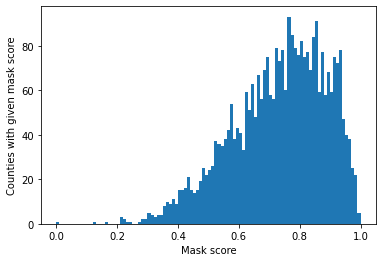

In [620]:
plt.hist(df_masks.mask_score, bins=100)
plt.xlabel('Mask score')
plt.ylabel('Counties with given mask score')
plt.show()

In [621]:
# Import the population density dataset
df_pops = pd.read_csv(initial_data + 'census-population-landarea.csv')
df_pops.head()

,fips,PST045212,PST040210,PST120212,POP010210,LND110210,POP060210
0,0,313914040,308747508,1.7,308745538,3531905.43,87.4
1,1000,4822023,4779745,0.9,4779736,50645.33,94.4
2,1001,55514,54571,1.7,54571,594.44,91.8
3,1003,190790,182265,4.7,182265,1589.78,114.6
4,1005,27201,27457,-0.9,27457,884.88,31.0


In [622]:
# Keep only the relevant columns
df_pops = df_pops[['fips', 'PST045212', 'LND110210']].rename({'fips' : 'county_fips_code', 'PST045212' : 'population', 'LND110210' : 'landarea'}, axis=1)
df_pops

,county_fips_code,population,landarea
0,0,313914040,3531905.43
1,1000,4822023,50645.33
2,1001,55514,594.44
3,1003,190790,1589.78
4,1005,27201,884.88
...,...,...,...
3190,56037,45267,10426.65
3191,56039,21675,3995.38
3192,56041,21025,2081.26
3193,56043,8464,2238.55


In [623]:
# Filter out rows that aren't present in the mask use dataset
df_pops = filter_county_rows(df_pops)
df_pops = df_pops.set_index('county_fips_code')
df_pops.head()

,population,landarea
county_fips_code,,
1001,55514,594.44
1003,190790,1589.78
1005,27201,884.88
1007,22597,622.58
1009,57826,644.78


In [624]:
# Calculate a 'pop_density' column
df_pops['pop_density'] = df_pops.population / df_pops.landarea
df_pops.head()

,population,landarea,pop_density
county_fips_code,,,
1001,55514,594.44,93.388736
1003,190790,1589.78,120.010316
1005,27201,884.88,30.739761
1007,22597,622.58,36.295737
1009,57826,644.78,89.683303


In [625]:
def calc_diffs(df, feature, delta):
    def calc_diff(i):
        return df.loc[(i+delta),feature] - df.loc[i,feature]
    return pd.Series(list(map(calc_diff, range(0, len(df) - delta))))

In [626]:
def change_features(df):
    deltas = [(1, 'daily'), (7, 'weekly'), (30, 'monthly')]
    fs = [(lambda s: s.max(), 'max'), (lambda s: s.mean(), 'mean')]
    features = [('confirmed_cases', 'cases'), ('deaths', 'deaths')]
    lbls = []
    vals = []
    for d,d_lbl in deltas:
        for f,f_lbl in fs:
            for ftr,ftr_lbl in features:
                lbls.append(d_lbl + '_change_' + ftr_lbl + '_' + f_lbl)
                vals.append(f(calc_diffs(df, ftr, d)))
    for ftr,ftr_lbl in features:
        lbls.append('total_change_' + ftr_lbl)
        vals.append(df.iloc[-1,:][ftr])
    return pd.Series(vals, index=lbls)

In [627]:
def summarize_df_counties():
    dfs = list(map(lambda code: df_counties[df_counties.county_fips_code == code].reset_index(), unique_county_codes))
    rows = list(map(change_features, dfs))
    df = pd.concat(rows, axis=1).T
    df['county_fips_code'] = unique_county_codes
    df = df.set_index('county_fips_code')
    return df

In [628]:
def get_counties_summary(force=False):
    write_loc = '../data/transformed/covid_us_counties_summ.csv'
    if force or not os.path.exists(write_loc):
        df = summarize_df_counties()
        df.to_csv(write_loc)
        return df
    else: 
        df = pd.read_csv(write_loc)
        df = df.set_index('county_fips_code')
        return df

In [629]:
df_counties_summ = get_counties_summary()

In [630]:
df_counties_summ

,daily_change_cases_max,daily_change_deaths_max,daily_change_cases_mean,daily_change_deaths_mean,weekly_change_cases_max,weekly_change_deaths_max,weekly_change_cases_mean,weekly_change_deaths_mean,monthly_change_cases_max,monthly_change_deaths_max,monthly_change_cases_mean,monthly_change_deaths_mean,total_change_cases,total_change_deaths
county_fips_code,,,,,,,,,,,,,,
1001,83.0,2.0,9.573460,0.142180,168.0,6.0,67.712195,0.970732,547.0,14.0,304.153846,4.351648,2021.0,30.0
1003,357.0,8.0,29.149321,0.312217,862.0,12.0,207.218605,2.195349,2490.0,22.0,930.135417,9.062500,6443.0,69.0
1005,20.0,2.0,4.950249,0.044776,92.0,2.0,35.051282,0.323077,272.0,4.0,157.773256,1.360465,996.0,9.0
1007,29.0,2.0,3.897561,0.068293,74.0,3.0,27.366834,0.467337,236.0,6.0,117.375000,1.926136,801.0,14.0
1009,38.0,7.0,8.914286,0.119048,179.0,8.0,62.328431,0.803922,647.0,11.0,278.458564,2.889503,1873.0,25.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56037,13.0,1.0,2.061611,0.009479,48.0,2.0,14.243902,0.068293,151.0,2.0,60.230769,0.329670,436.0,2.0
56039,20.0,1.0,3.290323,0.004608,85.0,1.0,23.222749,0.033175,224.0,1.0,94.324468,0.159574,715.0,1.0
56041,15.0,1.0,2.009901,0.009901,66.0,1.0,14.193878,0.071429,171.0,2.0,63.497110,0.346821,407.0,2.0


In [631]:
# Combine the datasets with the fips code as the index
df_combined = df_masks.reset_index().merge(df_pops.reset_index(), on='county_fips_code').set_index('county_fips_code').drop('index',axis=1)
df_combined = df_combined.reset_index().merge(df_counties_summ.reset_index(), on='county_fips_code').set_index('county_fips_code')#.drop('index',axis=1)
df_combined

,never,rarely,sometimes,frequently,always,mask_score,population,landarea,pop_density,daily_change_cases_max,...,weekly_change_cases_max,weekly_change_deaths_max,weekly_change_cases_mean,weekly_change_deaths_mean,monthly_change_cases_max,monthly_change_deaths_max,monthly_change_cases_mean,monthly_change_deaths_mean,total_change_cases,total_change_deaths
county_fips_code,,,,,,,,,,,,,,,,,,,,,
1001,0.053,0.074,0.134,0.295,0.444,0.796765,55514,594.44,93.388736,83.0,...,168.0,6.0,67.712195,0.970732,547.0,14.0,304.153846,4.351648,2021.0,30.0
1003,0.083,0.059,0.098,0.323,0.436,0.765844,190790,1589.78,120.010316,357.0,...,862.0,12.0,207.218605,2.195349,2490.0,22.0,930.135417,9.062500,6443.0,69.0
1005,0.067,0.121,0.120,0.201,0.491,0.718280,27201,884.88,30.739761,20.0,...,92.0,2.0,35.051282,0.323077,272.0,4.0,157.773256,1.360465,996.0,9.0
1007,0.020,0.034,0.096,0.278,0.572,0.911489,22597,622.58,36.295737,29.0,...,74.0,3.0,27.366834,0.467337,236.0,6.0,117.375000,1.926136,801.0,14.0
1009,0.053,0.114,0.180,0.194,0.459,0.736483,57826,644.78,89.683303,38.0,...,179.0,8.0,62.328431,0.803922,647.0,11.0,278.458564,2.889503,1873.0,25.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56037,0.061,0.295,0.230,0.146,0.268,0.513371,45267,10426.65,4.341471,13.0,...,48.0,2.0,14.243902,0.068293,151.0,2.0,60.230769,0.329670,436.0,2.0
56039,0.095,0.157,0.160,0.247,0.340,0.618291,21675,3995.38,5.425016,20.0,...,85.0,1.0,23.222749,0.033175,224.0,1.0,94.324468,0.159574,715.0,1.0
56041,0.098,0.278,0.154,0.207,0.264,0.484024,21025,2081.26,10.102054,15.0,...,66.0,1.0,14.193878,0.071429,171.0,2.0,63.497110,0.346821,407.0,2.0


In [632]:
change_features = list(df_counties_summ.columns)
measures = ['mask_score', 'always', 'never']

# Scale function: ((change in _ * landarea) / population^2) * 1000
# This corrects for different change quantities depending on population of county
# This also corrects for the density of population by muliplying by inverse of the density
def scale(ftr):
    return ((df_combined[ftr] * df_combined.landarea) / (df_combined.population * df_combined.population)) * 1000

In [633]:
# Define a new dataframe where we scale every attribute from summarized dataset
df_summ_scaled = pd.DataFrame(list(map(scale, change_features))).T
df_summ_scaled.columns = list(map(lambda s: 'scaled_' + s, change_features))
df_summ_scaled

,scaled_daily_change_cases_max,scaled_daily_change_deaths_max,scaled_daily_change_cases_mean,scaled_daily_change_deaths_mean,scaled_weekly_change_cases_max,scaled_weekly_change_deaths_max,scaled_weekly_change_cases_mean,scaled_weekly_change_deaths_mean,scaled_monthly_change_cases_max,scaled_monthly_change_deaths_max,scaled_monthly_change_cases_mean,scaled_monthly_change_deaths_mean,scaled_total_change_cases,scaled_total_change_deaths
county_fips_code,,,,,,,,,,,,,,
1001,0.016010,0.000386,0.001847,0.000027,0.032405,0.001157,0.013061,0.000187,0.105509,0.002700,0.058667,0.000839,0.389825,0.005787
1003,0.015592,0.000349,0.001273,0.000014,0.037647,0.000524,0.009050,0.000096,0.108749,0.000961,0.040623,0.000396,0.281393,0.003014
1005,0.023919,0.002392,0.005920,0.000054,0.110028,0.002392,0.041920,0.000386,0.325300,0.004784,0.188690,0.001627,1.191171,0.010764
1007,0.035358,0.002439,0.004752,0.000083,0.090225,0.003658,0.033367,0.000570,0.287744,0.007316,0.143110,0.002348,0.976621,0.017070
1009,0.007327,0.001350,0.001719,0.000023,0.034516,0.001543,0.012019,0.000155,0.124758,0.002121,0.053694,0.000557,0.361163,0.004821
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56037,0.066149,0.005088,0.010490,0.000048,0.244243,0.010177,0.072479,0.000348,0.768349,0.010177,0.306478,0.001677,2.218543,0.010177
56039,0.170087,0.008504,0.027982,0.000039,0.722868,0.008504,0.197494,0.000282,1.904969,0.008504,0.802166,0.001357,6.080593,0.008504
56041,0.070623,0.004708,0.009463,0.000047,0.310741,0.004708,0.066828,0.000336,0.805101,0.009416,0.298957,0.001633,1.916235,0.009416


In [634]:
def zip_index(lst):
        return zip(range(0, len(lst)), lst)

In [635]:
scaled_features = list(df_summ_scaled.columns)

def show_change_vs_masks():
    fig, axs = plt.subplots(len(scaled_features), len(measures), 
                            figsize=(50,50))
    # rows of subplots = change_features
    # columns of subplots = measures

    for (r, ftr) in zip_index(scaled_features):
        for (c, measure) in zip_index(measures):
            x = df_combined[measure]
            y = df_summ_scaled[ftr]
            axs[r][c].scatter(x, y)
            axs[r][c].set_ylabel(ftr)
            axs[r][c].set_xlabel(measure)
    fig.tight_layout()
    plt.show()

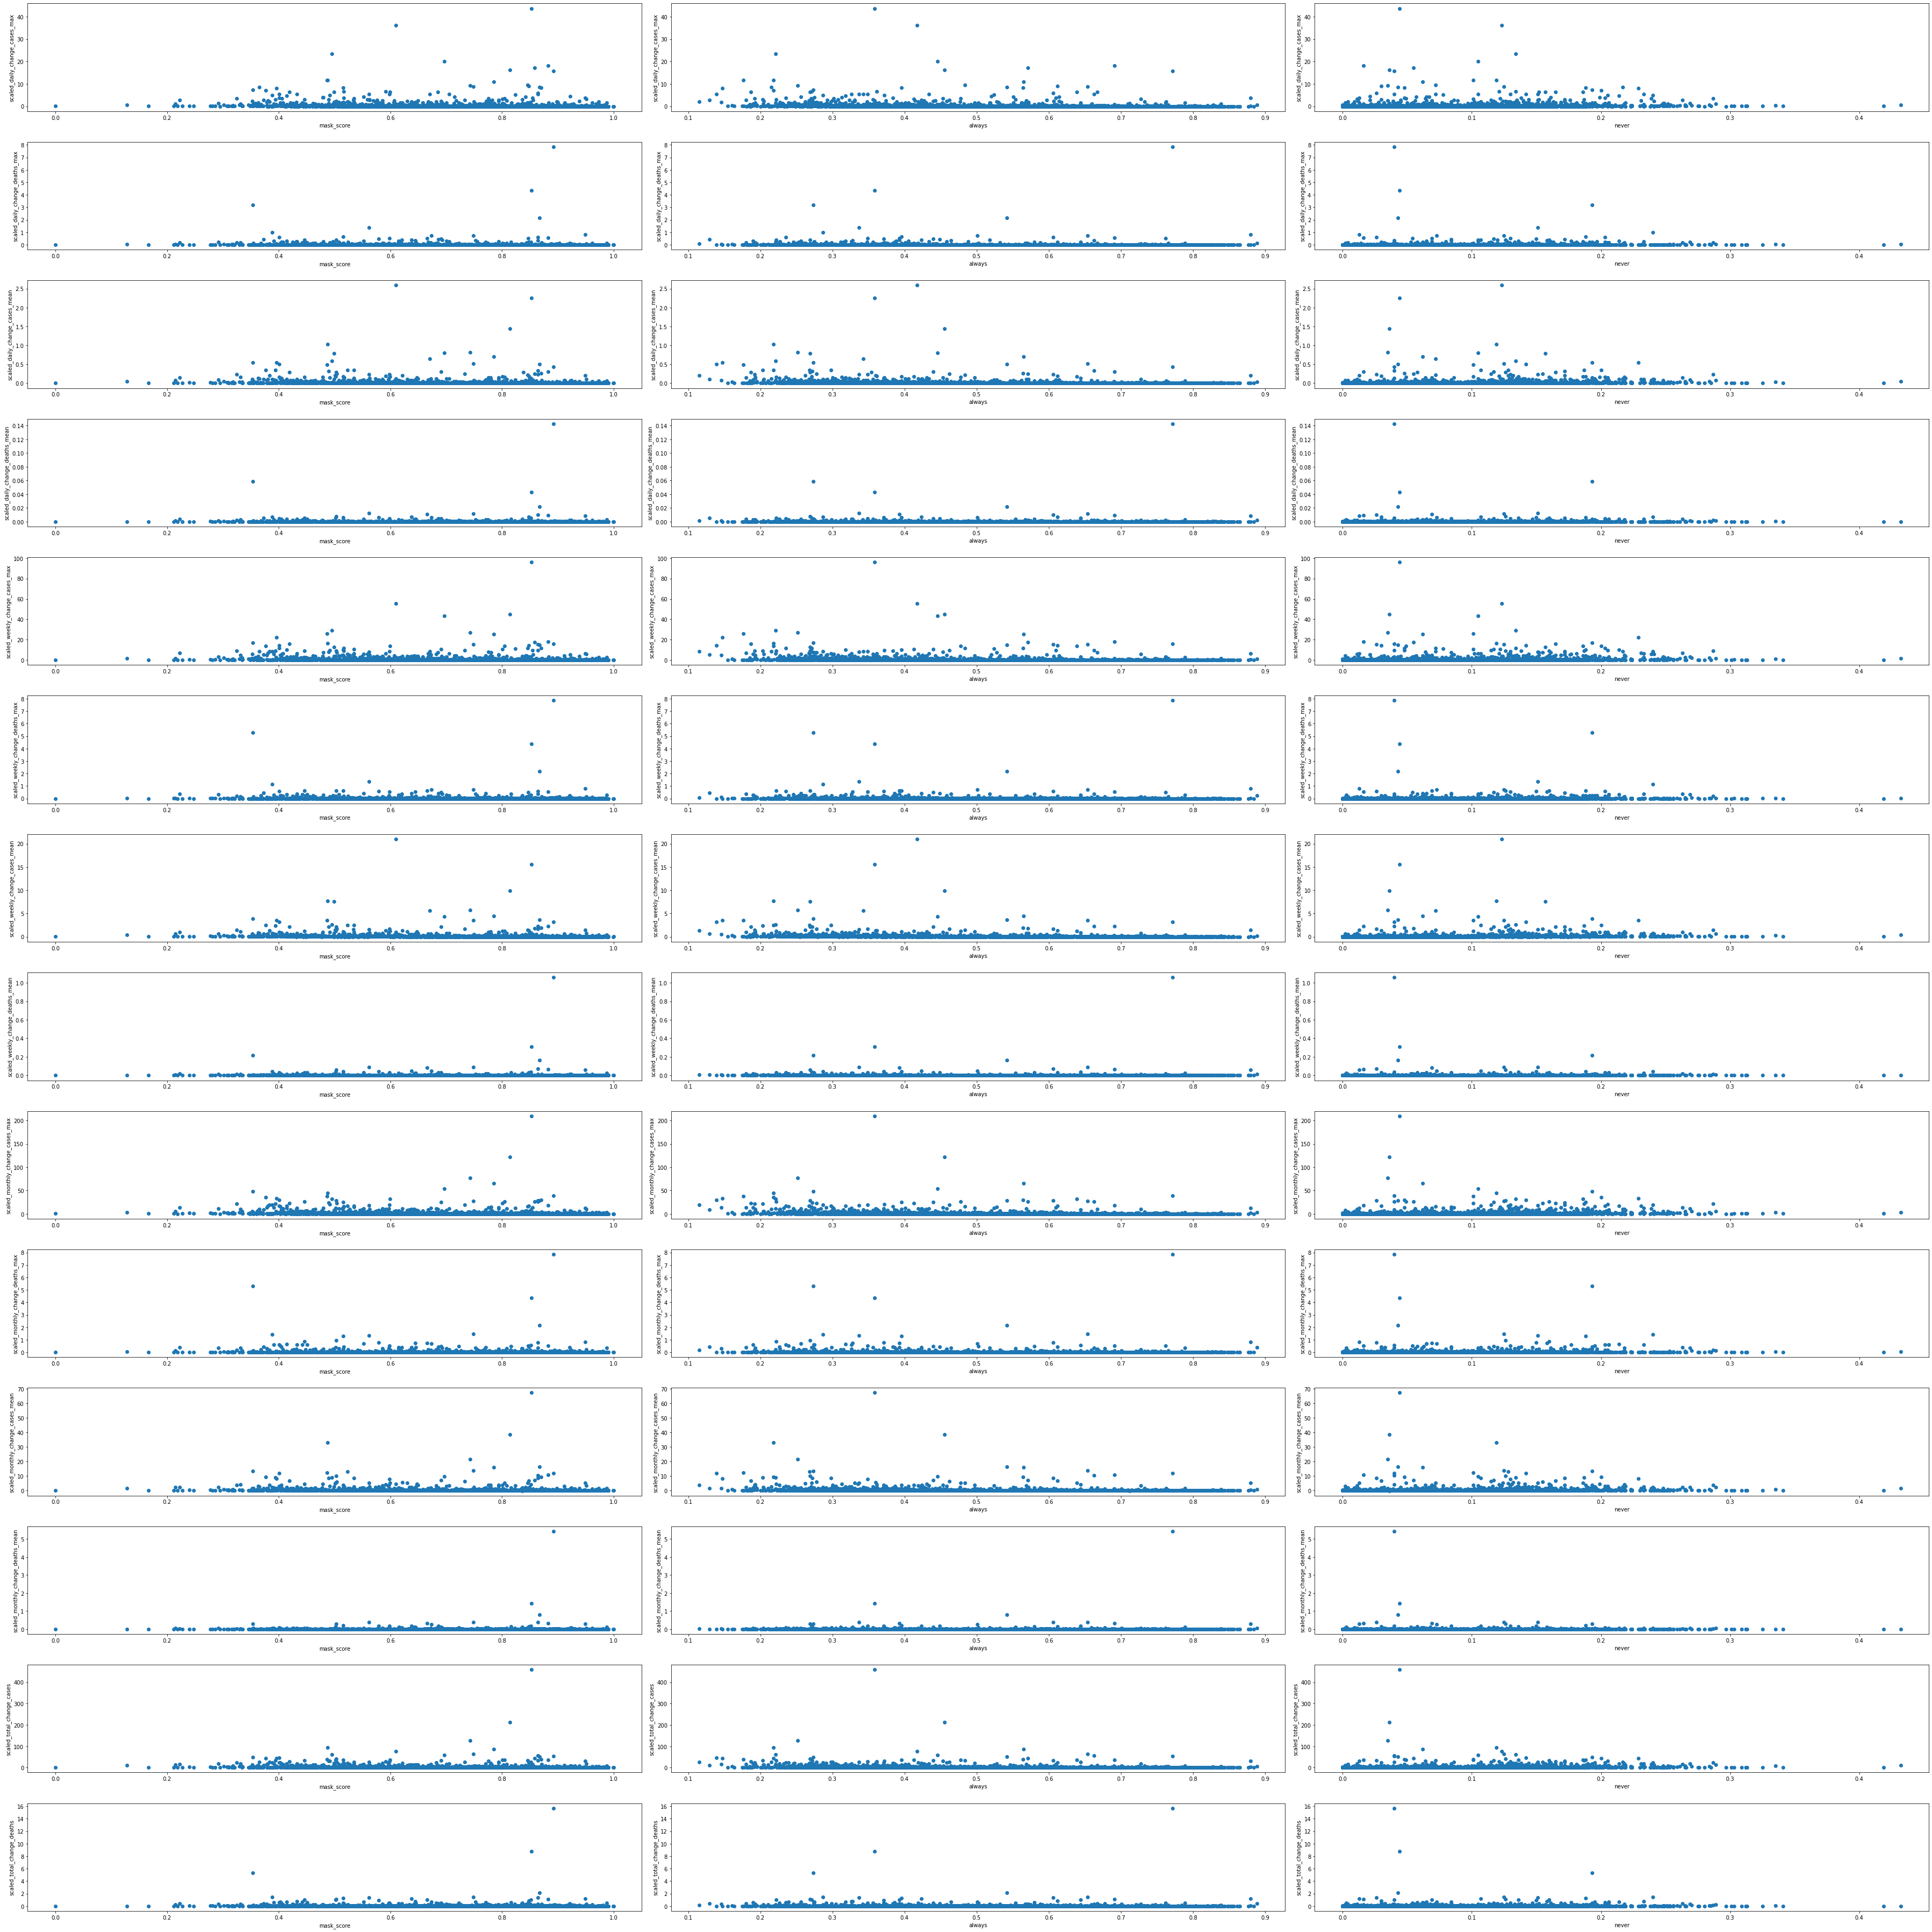

In [636]:
show_change_vs_masks()

In [637]:
# Showing mask-wearing correlations
df_combined[measures[0]].corr(df_summ_scaled[scaled_features[0]])

def col_corr(measure):
    def row_corr(ftr):
        return df_combined[measure].corr(df_summ_scaled[ftr])
    return list(map(row_corr, scaled_features))

def corrs():
    df = pd.DataFrame(list(map(col_corr, measures))).T
    df.columns = measures
    df.index = scaled_features
    return df

In [638]:
df_corrs = corrs()

In [639]:
def plot_corr_grid(df):
    plt.title('Correlations between cases/deaths and mask use')
    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(df, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

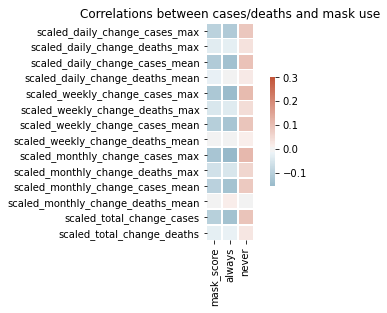

In [640]:
plot_corr_grid(df_corrs)